In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./382957.duckdb

Connecting to 'duckdb:///./382957.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-08 14:26:33.283334,�c��!�CF['�[auto_init_saul] initializing GPIO ...
1,2,70B3D57ED005E88A,2023-11-08 14:26:33.287307,[auto_init_saul] initializing GPIO #1\n
2,3,70B3D57ED005E88A,2023-11-08 14:26:33.290314,[auto_init_saul] initializing GPIO #2\n
3,4,70B3D57ED005E88A,2023-11-08 14:26:33.293297,[auto_init_saul] initializing GPIO #3\n
4,5,70B3D57ED005E88A,2023-11-08 14:26:33.297228,[auto_init_saul] initializing hts221 #0\n
...,...,...,...,...
619,620,70B3D57ED005E88A,2023-11-08 14:31:12.301158,collecting data from sensor lps22hb\n
620,621,70B3D57ED005E88A,2023-11-08 14:31:12.307207,Read value from Sensor lps22hb. Saving in env...
621,622,70B3D57ED005E88A,2023-11-08 14:31:12.308016,Execute Queries...\n
622,623,70B3D57ED005E88A,2023-11-08 14:31:12.311196,Sending Responses if any...\n


In [7]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [8]:

timestamps=%sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,70311,69802,35156.0,20297.18172554998,17595,35208,52791,70311,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,70311,0.0%
2,timestamp,TIMESTAMP,2023-11-08 14:26:07.566598,2023-11-08 14:31:13.265296,69779,None,None,None,None,None,70311,0.0%
3,current,FLOAT,-2.4e-05,0.104366,979,0.05881839365657254,0.01193774426602953,0.05583476105296227,0.0563497228394317,0.05698152412556813,70311,0.0%
4,voltage,FLOAT,0.78125,4.9225,481,4.8280505091344,0.3394831566941196,4.858749866485596,4.860000133514404,4.860000133514404,70311,0.0%
5,power,FLOAT,0.0,0.506691,359,0.28581324129335806,0.05794995782145741,0.27148485399955263,0.27408718089776213,0.276860366689374,70311,0.0%


In [9]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,70311,2023-11-08 14:26:07.566598,2023-11-08 14:31:13.265296


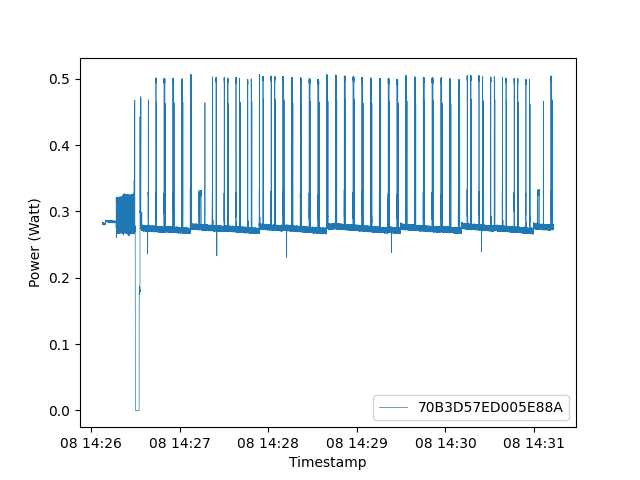

In [10]:
deveui = "70B3D57ED005EA56"

power_consumption= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

## finding sync signals

In [11]:
BLINK_HIGH_MS = 200
BLINK_LOW_MS = 200


#diff of each group
power_consumption['power_diff'] = groups["power"].diff()
power_diff = power_consumption['power_diff']

# single node
power_single = power_consumption[(power_consumption["node_id"] =="70B3D57ED005E88A")]


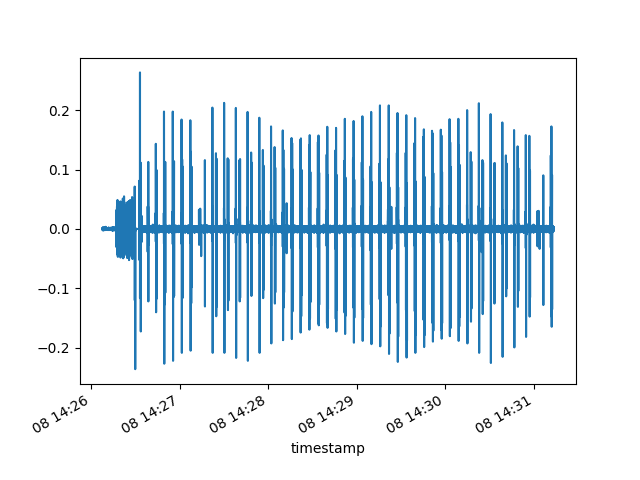

In [12]:
plt.figure()
power_diff.plot()
plt.show()

In [13]:
rising_edge = power_consumption[power_diff > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_diff < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2023-11-08 14:26:29.431525,0.271660,0.055846,4.85875,70B3D57ED005E88A,-0.120263,falling
2023-11-08 14:26:29.731540,0.000000,0.000122,2.31000,70B3D57ED005E88A,-0.236252,falling
2023-11-08 14:26:32.953151,0.442592,0.090936,4.86000,70B3D57ED005E88A,0.263724,rising
2023-11-08 14:26:32.957515,0.325992,0.067103,4.86000,70B3D57ED005E88A,-0.116600,falling
2023-11-08 14:26:33.431428,0.425499,0.087615,4.85875,70B3D57ED005E88A,0.111717,rising
...,...,...,...,...,...,...
2023-11-08 14:31:11.465242,0.499366,0.102877,4.85625,70B3D57ED005E88A,0.123926,rising
2023-11-08 14:31:11.665231,0.275323,0.056652,4.86125,70B3D57ED005E88A,-0.147123,falling
2023-11-08 14:31:11.878280,0.464569,0.095551,4.85750,70B3D57ED005E88A,0.172764,rising


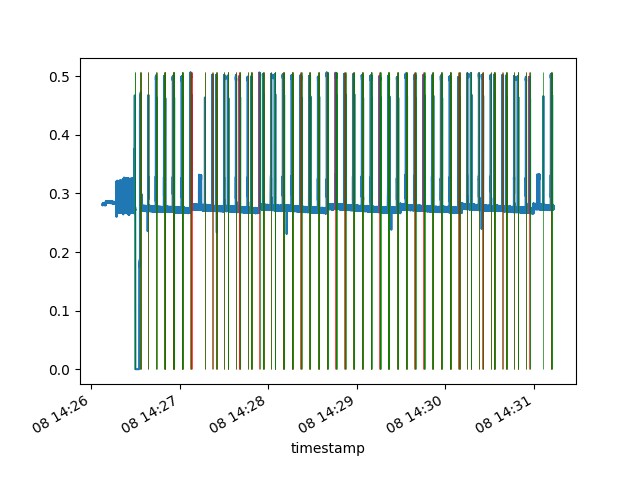

In [14]:
plt.figure()
power_single['power'].plot()
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [15]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)
edges = edges[(edges['direction'] != edges['next_direction']) & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=210))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=190)))]
edges


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp
timestamp,,,,,,,,
2023-11-08 14:26:43.683536,0.429772,0.088567,4.85625,70B3D57ED005E88A,0.143461,rising,falling,2023-11-08 14:26:43.883555
2023-11-08 14:26:49.226991,0.493871,0.101656,4.85500,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:49.426980
2023-11-08 14:26:49.644393,0.496313,0.102217,4.85500,70B3D57ED005E88A,0.105611,rising,falling,2023-11-08 14:26:49.844382
2023-11-08 14:26:55.179152,0.496313,0.102193,4.85625,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:55.379141
2023-11-08 14:26:55.596523,0.498755,0.102632,4.85625,70B3D57ED005E88A,0.100728,rising,falling,2023-11-08 14:26:55.792179
...,...,...,...,...,...,...,...,...
2023-11-08 14:30:48.969071,0.418783,0.086247,4.85750,70B3D57ED005E88A,0.139187,rising,falling,2023-11-08 14:30:49.169060
2023-11-08 14:30:54.508315,0.495092,0.101900,4.85500,70B3D57ED005E88A,0.158112,rising,falling,2023-11-08 14:30:54.708335
2023-11-08 14:30:56.921396,0.435877,0.089715,4.85875,70B3D57ED005E88A,0.156892,rising,falling,2023-11-08 14:30:57.121415


In [16]:
edges.loc[:,'sync_num'] = range(len(edges)) 
edges

/tmp/ipykernel_294181/4149730090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges.loc[:,'sync_num'] = range(len(edges))


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num
timestamp,,,,,,,,,
2023-11-08 14:26:43.683536,0.429772,0.088567,4.85625,70B3D57ED005E88A,0.143461,rising,falling,2023-11-08 14:26:43.883555,0
2023-11-08 14:26:49.226991,0.493871,0.101656,4.85500,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:49.426980,1
2023-11-08 14:26:49.644393,0.496313,0.102217,4.85500,70B3D57ED005E88A,0.105611,rising,falling,2023-11-08 14:26:49.844382,2
2023-11-08 14:26:55.179152,0.496313,0.102193,4.85625,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:55.379141,3
2023-11-08 14:26:55.596523,0.498755,0.102632,4.85625,70B3D57ED005E88A,0.100728,rising,falling,2023-11-08 14:26:55.792179,4
...,...,...,...,...,...,...,...,...,...
2023-11-08 14:30:48.969071,0.418783,0.086247,4.85750,70B3D57ED005E88A,0.139187,rising,falling,2023-11-08 14:30:49.169060,72
2023-11-08 14:30:54.508315,0.495092,0.101900,4.85500,70B3D57ED005E88A,0.158112,rising,falling,2023-11-08 14:30:54.708335,73
2023-11-08 14:30:56.921396,0.435877,0.089715,4.85875,70B3D57ED005E88A,0.156892,rising,falling,2023-11-08 14:30:57.121415,74


In [17]:
#based on sync_num add loop timings
edges.loc[:,'loop_num'] = ((edges['sync_num'] - 1) // 2)
edges

/tmp/ipykernel_294181/2219274201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges.loc[:,'loop_num'] = ((edges['sync_num'] - 1) // 2)


,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,loop_num
timestamp,,,,,,,,,,
2023-11-08 14:26:43.683536,0.429772,0.088567,4.85625,70B3D57ED005E88A,0.143461,rising,falling,2023-11-08 14:26:43.883555,0,-1
2023-11-08 14:26:49.226991,0.493871,0.101656,4.85500,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:49.426980,1,0
2023-11-08 14:26:49.644393,0.496313,0.102217,4.85500,70B3D57ED005E88A,0.105611,rising,falling,2023-11-08 14:26:49.844382,2,0
2023-11-08 14:26:55.179152,0.496313,0.102193,4.85625,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:55.379141,3,1
2023-11-08 14:26:55.596523,0.498755,0.102632,4.85625,70B3D57ED005E88A,0.100728,rising,falling,2023-11-08 14:26:55.792179,4,1
...,...,...,...,...,...,...,...,...,...,...
2023-11-08 14:30:48.969071,0.418783,0.086247,4.85750,70B3D57ED005E88A,0.139187,rising,falling,2023-11-08 14:30:49.169060,72,35
2023-11-08 14:30:54.508315,0.495092,0.101900,4.85500,70B3D57ED005E88A,0.158112,rising,falling,2023-11-08 14:30:54.708335,73,36
2023-11-08 14:30:56.921396,0.435877,0.089715,4.85875,70B3D57ED005E88A,0.156892,rising,falling,2023-11-08 14:30:57.121415,74,36


In [18]:
# create table of loops by taking every second row and excluding the first edge (which is just program start)
# the index is when (we think) the loop starts. that is 200 ms after next_timestamp.
# also remove all irrelevant columns

loops = edges[['node_id', 'next_timestamp', 'loop_num']].iloc[1::2,:]
## change index to be loop start time. i.e. 200 ms after next timestamp
loops['loop_start'] = loops.next_timestamp + pd.Timedelta(milliseconds=200)
loops.set_index('loop_start', inplace=True)
loops.drop('next_timestamp', axis=1, inplace=True)
loops.head()

,node_id,loop_num
loop_start,,
2023-11-08 14:26:49.626980,70B3D57ED005E88A,0
2023-11-08 14:26:55.579141,70B3D57ED005E88A,1
2023-11-08 14:27:01.531301,70B3D57ED005E88A,2
2023-11-08 14:27:07.483492,70B3D57ED005E88A,3
2023-11-08 14:27:22.440010,70B3D57ED005E88A,4


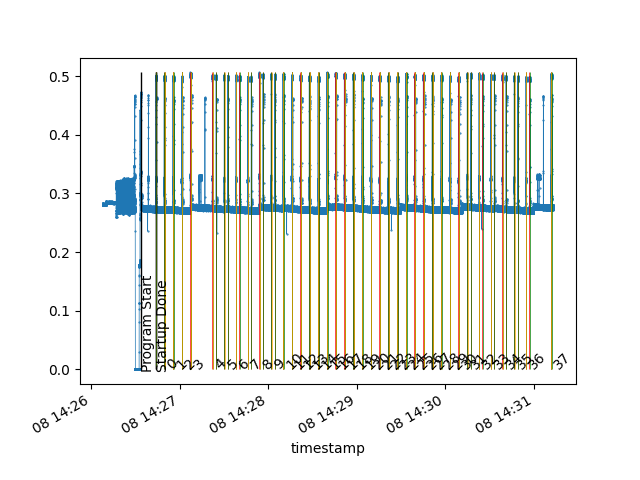

In [19]:
plt.figure()
power_single['power'].plot(style='.',markersize=1)
power_single['power'].plot(linewidth=0.5, color='tab:blue')

# when does the program start?
%sql program_start << select timestamp from Trace WHERE message LIKE 'Terra%'
%sql startup_done << select timestamp from Trace WHERE message LIKE 'Startup done.%'
# add line indicating program start
plt.vlines(program_start['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1)
plt.text(program_start['timestamp'], 0, "Program Start", rotation=90)

# add line indicating startup done
plt.vlines(startup_done['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1)
plt.text(startup_done['timestamp'], 0, "Startup Done", rotation=90)

plt.vlines(startup_done['timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="black", linewidth=1)
plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5)
for row in loops.itertuples():

    #odd row num indicates start sync
    plt.text(row.Index, 0, row.loop_num, rotation=45)
plt.show()

In [20]:
%%sql
timings << 
select 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: ([0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: ([0-9]+)',1) as sync_time,
    regexp_extract(message, '.*Listen: ([0-9]+)',1) as listen_time,
    regexp_extract(message, '.*Collect: ([0-9]+)',1) as collect_time,
    regexp_extract(message, '.*Exec: ([0-9]+)',1) as exec_time,
    regexp_extract(message, '.*Send: ([0-9]+)',1) as send_time,
    regexp_extract(message, '.*Sleep: ([0-9]+)',1) as sleep_time,
    regexp_extract(message, '.*Total: ([0-9]+)',1) as total_time
     from Trace WHERE message LIKE 'TIMINGS>%'

In [21]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']] = timings[['loop_num', 'sync_time', 'listen_time', 'collect_time', 'exec_time', 'send_time', 'sleep_time', 'total_time']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('timestamp')
loops.head()

,loop_start,node_id,loop_num,sync_time,listen_time,collect_time,exec_time,send_time,sleep_time,total_time
timestamp,,,,,,,,,,
2023-11-08 14:26:49.634424,2023-11-08 14:26:49.626980,70B3D57ED005E88A,0,403,0,27,0,5103,0,5538
2023-11-08 14:26:55.586639,2023-11-08 14:26:55.579141,70B3D57ED005E88A,1,403,0,28,0,5098,0,5533
2023-11-08 14:27:01.538635,2023-11-08 14:27:01.531301,70B3D57ED005E88A,2,402,0,28,0,5099,0,5533
2023-11-08 14:27:07.490672,2023-11-08 14:27:07.483492,70B3D57ED005E88A,3,402,0,28,0,5099,0,5533
2023-11-08 14:27:22.447766,2023-11-08 14:27:22.440010,70B3D57ED005E88A,4,402,0,28,0,14104,0,14538


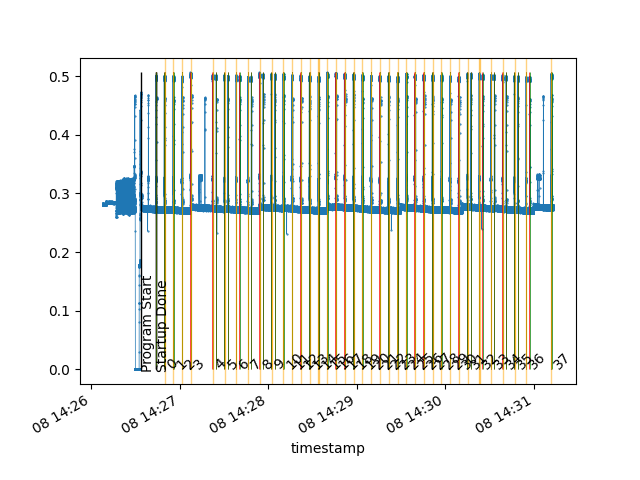

In [24]:
for row in loops.itertuples():
    plt.axvspan(row.Index, row.Index + pd.Timedelta(milliseconds=row.collect_time), color="orange", alpha=0.5)

plt.show()

In [ ]:
# join with loops table
loops.merge(timings)
    

,node_id,loop_num,timestamp,sync_time,listen_time,collect_time,exec_time,send_time,sleep_time,total_time
0,70B3D57ED005E88A,0,2023-11-08 14:26:49.634424,403,0,27,0,5103,0,5538
1,70B3D57ED005E88A,1,2023-11-08 14:26:55.586639,403,0,28,0,5098,0,5533
2,70B3D57ED005E88A,2,2023-11-08 14:27:01.538635,402,0,28,0,5099,0,5533
3,70B3D57ED005E88A,3,2023-11-08 14:27:07.490672,402,0,28,0,5099,0,5533
4,70B3D57ED005E88A,4,2023-11-08 14:27:22.447766,402,0,28,0,14104,0,14538
5,70B3D57ED005E88A,5,2023-11-08 14:27:30.399857,403,0,28,0,5098,0,5533
6,70B3D57ED005E88A,6,2023-11-08 14:27:38.352182,403,0,28,0,5098,0,5533
7,70B3D57ED005E88A,7,2023-11-08 14:27:46.304264,403,0,28,0,5098,0,5533
8,70B3D57ED005E88A,8,2023-11-08 14:27:54.256213,403,0,28,0,5098,0,5533
9,70B3D57ED005E88A,9,2023-11-08 14:28:02.208467,403,0,28,0,5098,0,5533


In [ ]:
## add timings to edges
edges.merge(timings, on=['node_id', 'loop_num'], how='left')
edges

,power,current,voltage,node_id,power_diff,direction,next_direction,next_timestamp,sync_num,loop_num
timestamp,,,,,,,,,,
2023-11-08 14:26:43.683536,0.429772,0.088567,4.85625,70B3D57ED005E88A,0.143461,rising,falling,2023-11-08 14:26:43.883555,0,-1
2023-11-08 14:26:49.226991,0.493871,0.101656,4.85500,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:49.426980,1,0
2023-11-08 14:26:49.644393,0.496313,0.102217,4.85500,70B3D57ED005E88A,0.105611,rising,falling,2023-11-08 14:26:49.844382,2,0
2023-11-08 14:26:55.179152,0.496313,0.102193,4.85625,70B3D57ED005E88A,0.197792,rising,falling,2023-11-08 14:26:55.379141,3,1
2023-11-08 14:26:55.596523,0.498755,0.102632,4.85625,70B3D57ED005E88A,0.100728,rising,falling,2023-11-08 14:26:55.792179,4,1
...,...,...,...,...,...,...,...,...,...,...
2023-11-08 14:30:48.969071,0.418783,0.086247,4.85750,70B3D57ED005E88A,0.139187,rising,falling,2023-11-08 14:30:49.169060,72,35
2023-11-08 14:30:54.508315,0.495092,0.101900,4.85500,70B3D57ED005E88A,0.158112,rising,falling,2023-11-08 14:30:54.708335,73,36
2023-11-08 14:30:56.921396,0.435877,0.089715,4.85875,70B3D57ED005E88A,0.156892,rising,falling,2023-11-08 14:30:57.121415,74,36


In [ ]:
%%sql
res <<
select timestamp, AVG(power) OVER blink AS 'avg_power_blink'
FROM Power_Consumption
WINDOW blink AS (
    PARTITION BY node_id
    ORDER BY timestamp ASC
    RANGE BETWEEN INTERVAL 100 MILLISECOND PRECEDING AND INTERVAL 100 MILLISECOND FOLLOWING
    )

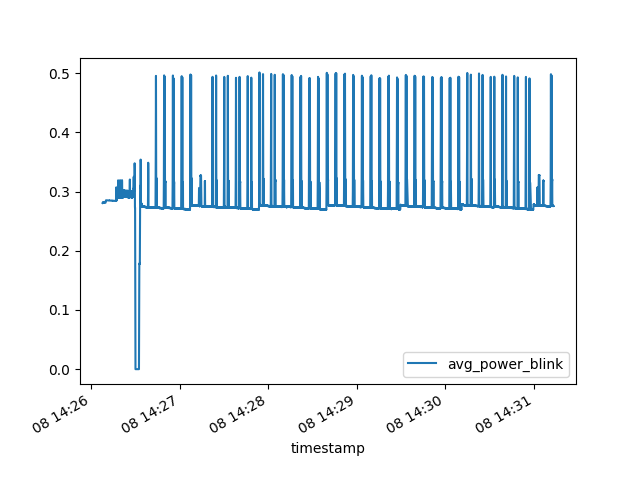

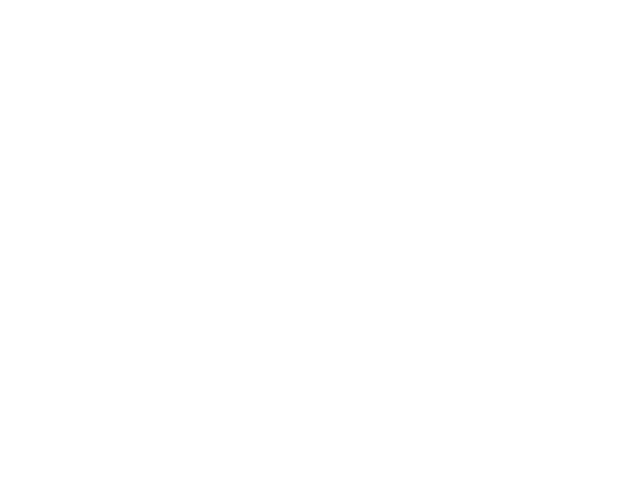

In [ ]:
plt.figure()
res.plot(x='timestamp')
plt.show()

In [ ]:
# Clean edge detection
#remove values where difference is not greater or less than 5 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=5.5))  & (diff > pd.Timedelta(seconds=4.5))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

NameError: name 'filtered_power_diff' is not defined

In [ ]:
%sql select count(*) from Trace

,count_star()
0,607


In [ ]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [ ]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A' AND message LIKE '>TIMINGS%'

,trace_id,node_id,timestamp,message


In [ ]:
def get_timings_from_trace(trace: str):
    

SyntaxError: incomplete input (2969963752.py, line 2)

In [ ]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'